Teorema de Bayes:

$P(A|B)$ = $\frac{P(B|A)P(A)}{P(B)}$

sendo $P(B|A)$ a probabilidade condicional de B dado A.

Classificador Naive Bayes:

Para cada entrada x, predizer a classe y em que aquele valor provavelmete pertence.

Para o treinamento do classificador, o dataset terá N pares (x,y) de exemplos resolvidos. 

Distribuição dos dados:

$P(x,y)$ = $P(x)P(y|x)$

$P(x)$ é a distribuição dos dados de entrada

$P(y|x)$ é a distribuição condicional da saída dada a entrada

A utilização de $P(y|x)$ nem sempre ocorre da melhor forma, já que é necessário obter o valor de $P(y|x)$ e nem sempre isso é possível. Portanto, a implementação do classificador é feita por aproximações de $P(y|x)$

Uma das formas de obter $P(x|y)$ é através da contagem de ocorrências no dataset.

No caso da classificação de emails como spam, inicia-se contando a ocorrência de palavras únicas.

Por exemplo, no dataset há 265 emails que possuem a palavra 'Vendas' e, deste total, 199 são classificados como spam. Portanto, neste caso, $P(y|x)$ para email que contenham 'Vendas' é de $\frac{199}{265}$ = 75%.

Em email que 'Vendas' não estão presentes, por exemplo, há 5307 e, dentro destes, 548 eram spam. Portanto $P(y|x)$ para emails que não contém 'Vendas' é de $\frac{548}{5307}$ = 10%

Analisar uma palavra não é suficiente para o classificador. Desta forma, é preciso analisar, também, palavras em conjunto, como, por exemplo, 'Vendas hoje'

Como não é viável contruir um dataset contendo as combinações de todas as palavras e classificá-los como spam ou não, a sáida é associar várias palavras à classificação.

$P(x_1, x_2, ..., x_n|y)$ = $P(x_1|y) * P(x_2|y) * ... * P(x_n|y)$

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
df = pd.read_csv('Iris.csv')

# Extract the color from the fourth column
df['Species'] = df['Species'].str.replace('Iris-', '').apply(lambda x: x.capitalize())

# Print the updated dataframe
print(df.head())

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm Species
0   1            5.1           3.5            1.4           0.2  Setosa
1   2            4.9           3.0            1.4           0.2  Setosa
2   3            4.7           3.2            1.3           0.2  Setosa
3   4            4.6           3.1            1.5           0.2  Setosa
4   5            5.0           3.6            1.4           0.2  Setosa


$$P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)}$$

$$P(Y|X_0,X_1,X_2,X_3) = \frac{P(X_0,X_1,X_2,X_3|Y)P(Y)}{P(X_0,X_1,X_2,X_3)}$$


 Supondo independência:


 $$P(Y|X_0,X_1,X_2,X_3) = \frac{P(X_0|Y)P(X_1|Y)P(X_2|Y)P(X_3|Y)P(Y)}{P(X_0,X_1,X_2,X_3)} $$

 Como as features são contínuas, vamo supor que sua distribuição condicionada a $Y$ é dada por uma Normal, ou seja, 

 $$ P(X_i|Y) \sim N(\mu,\sigma) $$


 Mas como calculamos $ P(X) $ ?

 Usando Probabilidade Marginal!

 $$P(X) = \Sigma_{Y = 0}^{Y<3} P(X_0|Y)P(X_1|Y)P(X_2|Y)P(X_3|Y)P(Y) $$

Cada Condicional é dada por:

$$ P(X_i|Y) = \frac{1}{\sqrt{2 \pi \sigma ^2}} e ^{ -\frac{1}{2} (\frac{x-\mu}{\sigma})^2 }$$

In [39]:
from math import e
from math import pi


def gaussian( x , mu, sigma ):
  return (1/(2*pi*sigma*sigma)**0.5) * e ** ((-1/2) * (((x-mu)/(sigma))**2) ) 


gaussian(0,0,1)

0.3989422804014327

In [40]:
from sklearn.model_selection import train_test_split

X = df.drop('Species',axis=1)
y = df['Species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [41]:
class ContinuousNB():
  
  def __init__(self, f):
    self.f = f

  def fit(self,X,y):
    # para cada classe de y, calcular média e desvio padrao para cada feature
    # está na ordem SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
    X['Y'] = y
    
    self.mean_versicolor = X.loc[ X['Y'] == 'Versicolor'].mean().values.tolist()
    print(self.mean_versicolor)
    self.mean_virginica = X.loc[ X['Y'] == 'Virginica'].mean().values.tolist()
    self.mean_setosa = X.loc[ X['Y'] == 'Setosa'].mean().values.tolist()

    self.std_versicolor = X.loc[ X['Y'] == 'Versicolor'].std().values.tolist()
    self.std_virginica = X.loc[ X['Y'] == 'Virginica'].std().values.tolist()
    self.std_setosa = X.loc[ X['Y'] == 'Setosa'].std().values.tolist()

    self.p_versicolor = X.loc[ X['Y'] == 'Versicolor'].shape[0]/X.shape[0]
    self.p_virginica = X.loc[ X['Y'] == 'Virginica'].shape[0]/X.shape[0]
    self.p_setosa = X.loc[ X['Y'] == 'Setosa'].shape[0]/X.shape[0]


  def predict(self,X):

    pred = []

    for instance in X.values:
      p_x_given_versicolor = self.f(instance[0],self.mean_versicolor[0],self.std_versicolor[0]) * self.f(instance[1],self.mean_versicolor[1],self.std_versicolor[1]) * self.f(instance[2],self.mean_versicolor[2],self.std_versicolor[2]) * self.f(instance[3],self.mean_versicolor[3],self.std_versicolor[3])
      p_x_given_virginica = self.f(instance[0],self.mean_virginica[0],self.std_virginica[0]) * self.f(instance[1],self.mean_virginica[1],self.std_virginica[1]) * self.f(instance[2],self.mean_virginica[2],self.std_virginica[2]) * self.f(instance[3],self.mean_virginica[3],self.std_virginica[3])
      p_x_given_setosa = self.f(instance[0],self.mean_setosa[0],self.std_setosa[0]) * self.f(instance[1],self.mean_setosa[1],self.std_setosa[1]) * self.f(instance[2],self.mean_setosa[2],self.std_setosa[2]) * self.f(instance[3],self.mean_setosa[3],self.std_setosa[3])
      
      p_x = p_x_given_versicolor*self.p_versicolor + p_x_given_virginica*self.p_virginica + p_x_given_setosa*self.p_setosa


      p_y_given_x = np.zeros(3)

      p_y_given_x[0] = (p_x_given_versicolor*self.p_versicolor)/p_x
      p_y_given_x[1] = (p_x_given_virginica*self.p_virginica)/p_x
      p_y_given_x[2] = (p_x_given_setosa*self.p_setosa)/p_x

      if np.argmax(p_y_given_x) == 0:
        pred.append('Versicolor')
      elif np.argmax(p_y_given_x) == 1:
        pred.append('Virginica')
      else:
        pred.append('Setosa')
        
    return pred

In [42]:
model = ContinuousNB(gaussian)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

[77.02857142857142, 5.851428571428571, 2.7257142857142855, 4.22, 1.3085714285714285]


/tmp/ipykernel_7081/4178827371.py:11: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  self.mean_versicolor = X.loc[ X['Y'] == 'Versicolor'].mean().values.tolist()
/tmp/ipykernel_7081/4178827371.py:13: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  self.mean_virginica = X.loc[ X['Y'] == 'Virginica'].mean().values.tolist()
/tmp/ipykernel_7081/4178827371.py:14: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is de

In [43]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_pred)

1.0

Text(113.9222222222222, 0.5, 'Predicted')

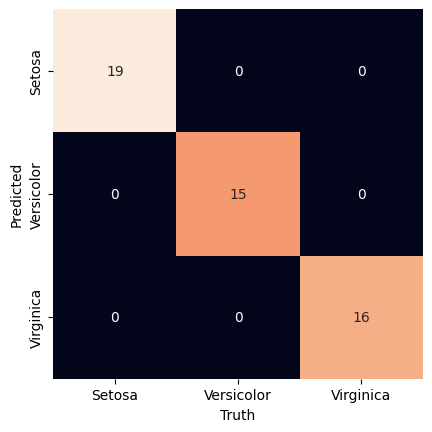

In [44]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_pred, y_test)
names = np.unique(y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names, yticklabels=names)
plt.xlabel('Truth')
plt.ylabel('Predicted')